# Capstone Project
## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [256]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [257]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image

import numpy as np
import random
import json

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

#### Import the data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q

You should store the unzipped folder in Drive for use in this Colab notebook.

In [258]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [259]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('gdrive/MyDrive/MyShares/En_GR dataset/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [260]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

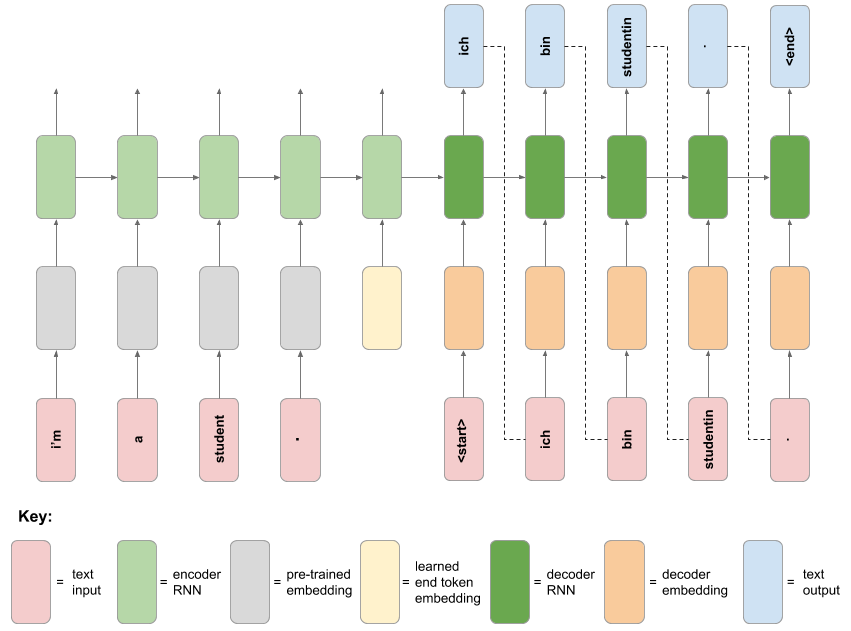

In [261]:
# Run this cell to download and view a schematic diagram for the neural translation model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [262]:
English_sentence = []
German_sentence = []

for sent in data_examples:
    period = sent.index("\t")
    BY = sent.index('BY')
    English_sentence.append(sent[0:period])
    German_sentence.append(sent[period+1:BY-4])
    
print(English_sentence[1500])
print(German_sentence[1500])

They agree.
Sie stimmen zu.


In [263]:
preprocessed_En = []
preprocessed_Gr = []
for sentence in English_sentence:
    preprocessed_En.append(preprocess_sentence(sentence))
    
for sentence in German_sentence:
    preprocessed_Gr.append(preprocess_sentence(sentence))
    
print(preprocessed_En[67])
max_length = 0
for sentence in preprocessed_Gr:
    if len(sentence) > max_length:
        max_length = len(sentence)
        
print(max_length)

be cool .
73


In [264]:
modified_gr = []

for sentence in preprocessed_Gr:
    sentence = "<start> " + sentence + " <end>"
    modified_gr.append(sentence)
    
modified_gr[:20]
#print(len(max(modified_gr))) 46

['<start> hallo ! <end>',
 '<start> gruess gott ! <end>',
 '<start> lauf ! <end>',
 '<start> potzdonner ! <end>',
 '<start> donnerwetter ! <end>',
 '<start> feuer ! <end>',
 '<start> hilfe ! <end>',
 '<start> zu huelf ! <end>',
 '<start> stopp ! <end>',
 '<start> warte ! <end>',
 '<start> mach weiter . <end>',
 '<start> hallo ! <end>',
 '<start> ich rannte . <end>',
 '<start> ich verstehe . <end>',
 '<start> aha . <end>',
 '<start> ich probiere es . <end>',
 '<start> ich hab gewonnen ! <end>',
 '<start> ich habe gewonnen ! <end>',
 '<start> laecheln ! <end>',
 '<start> zum wohl ! <end>']

In [265]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None,split=' ',
                       filters='',lower=True)

tokenizer.fit_on_texts(modified_gr)

In [266]:
tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [267]:
tokenizer_config['word_index']

'{"<start>": 1, "<end>": 2, ".": 3, "ich": 4, "tom": 5, "ist": 6, "?": 7, "sie": 8, "!": 9, "es": 10, "das": 11, "nicht": 12, "du": 13, "er": 14, "bin": 15, "hat": 16, "wir": 17, "habe": 18, "ein": 19, "zu": 20, "mir": 21, "mich": 22, "sind": 23, "war": 24, ",": 25, "die": 26, "ihr": 27, "dich": 28, "auf": 29, "kann": 30, "uns": 31, "bist": 32, "hier": 33, "sich": 34, "haben": 35, "an": 36, "eine": 37, "was": 38, "werde": 39, "einen": 40, "aus": 41, "wie": 42, "wer": 43, "ihn": 44, "gehen": 45, "in": 46, "der": 47, "wird": 48, "gut": 49, "mein": 50, "mag": 51, "dir": 52, "den": 53, "sein": 54, "mit": 55, "sehr": 56, "euch": 57, "hast": 58, "geht": 59, "meine": 60, "liebe": 61, "jetzt": 62, "da": 63, "lass": 64, "nach": 65, "will": 66, "bitte": 67, "wurde": 68, "werden": 69, "so": 70, "kein": 71, "noch": 72, "seid": 73, "komm": 74, "hause": 75, "mal": 76, "fuer": 77, "alle": 78, "mach": 79, "gerade": 80, "koennen": 81, "auto": 82, "wo": 83, "weiss": 84, "muss": 85, "machen": 86, "hatte"

In [268]:
res = json.loads(tokenizer_config['word_index'])

max_german_tokens = max(res.values())

print(max_german_tokens)


5743


In [269]:
padded_tonkenized_German = tokenizer.texts_to_sequences(modified_gr)

for _ in range(10):
    rand = random.randint(0, 20000)
    print(preprocessed_En[rand])
    print(modified_gr[rand])
    print(padded_tonkenized_German[rand])
    print('*************')

we're tom's sons .
<start> wir sind toms soehne . <end>
[1, 17, 23, 156, 964, 3, 2]
*************
what's happened ?
<start> was ist geschehen ? <end>
[1, 38, 6, 832, 7, 2]
*************
it's for us .
<start> es ist fuer uns . <end>
[1, 10, 6, 77, 31, 3, 2]
*************
we'll go see tom .
<start> wir gehen zu tom . <end>
[1, 17, 45, 20, 5, 3, 2]
*************
come help me .
<start> komm und hilf mir ! <end>
[1, 74, 161, 543, 21, 9, 2]
*************
did i wake tom up ?
<start> habe ich tom aufgeweckt ? <end>
[1, 18, 4, 5, 2155, 7, 2]
*************
take cover !
<start> geht in deckung ! <end>
[1, 59, 46, 1241, 9, 2]
*************
what'll you wear ?
<start> was ziehst du an ? <end>
[1, 38, 5381, 13, 36, 7, 2]
*************
i want a dog .
<start> ich will einen hund haben . <end>
[1, 4, 66, 40, 107, 35, 3, 2]
*************
he is up to date .
<start> er ist auf dem laufenden . <end>
[1, 14, 6, 29, 118, 1408, 3, 2]
*************


In [270]:
padded_german = tf.keras.preprocessing.sequence.pad_sequences(
    padded_tonkenized_German, padding="post")

padded_german_numpy = np.array(padded_german)

padded_german_numpy.shape

(20000, 14)

## 2. Prepare the data

#### Load the embedding layer
As part of the dataset preproceessing for this project, you will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [271]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [272]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

You should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful._
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [273]:
from sklearn.model_selection import train_test_split
english_train, english_test, german_train, german_test = train_test_split(preprocessed_En, 
                                                                          padded_german_numpy, test_size = 0.2)

In [274]:
train_dataset = tf.data.Dataset.from_tensor_slices((english_train , german_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((english_test , german_test))

print(train_dataset.element_spec)

for elem in train_dataset.take(1):
    print(elem[0])

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
tf.Tensor(b'the curtain rose .', shape=(), dtype=string)


In [275]:
def split_en_sentence(x , y):
    return tf.strings.split(x, ' '), y

train_dataset = train_dataset.map(split_en_sentence)
validation_dataset = validation_dataset.map(split_en_sentence)

splited_train_En_dataset.element_spec

for elem in splited_train_En_dataset.take(1):
    print(elem[0].shape)

(4,)


In [276]:
def embedding_sentence(x , y):
    return embedding_layer(x), y


train_dataset = train_dataset.map(embedding_sentence)
validation_dataset = validation_dataset.map(embedding_sentence)

print(train_dataset.element_spec)

for elem in train_dataset.take(1):
    print(elem[0].shape)

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
(4, 128)


In [277]:
maxlen = 13

train_dataset = train_dataset.filter(lambda x, y: False if ((tf.shape(x)[0]) >maxlen) else True)
validation_dataset = validation_dataset.filter(lambda x, y: False if ((tf.shape(x)[0]) > maxlen) else True)


In [278]:

def map_pad_dataset(x, y):

  return tf.pad(x, paddings=[[13 - len(x), 0], [0,0]]), y

train_dataset = train_dataset.map(map_pad_dataset)  
validation_dataset = validation_dataset.map(map_pad_dataset) 

print(pad_En_seq_traning.element_spec)

(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))


In [279]:
train_dataset = train_dataset.batch(16 ,drop_remainder=True)
validation_dataset = validation_dataset.batch(16,drop_remainder=True)

print(train_dataset.element_spec)
print(validation_dataset.element_spec)

(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))
(TensorSpec(shape=(16, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))


In [280]:
for elem in train_dataset.take(1):
    print(elem[0].shape)
for elem in validation_dataset.take(1):
    print(elem[1].shape)

(16, 13, 128)
(16, 14)


## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

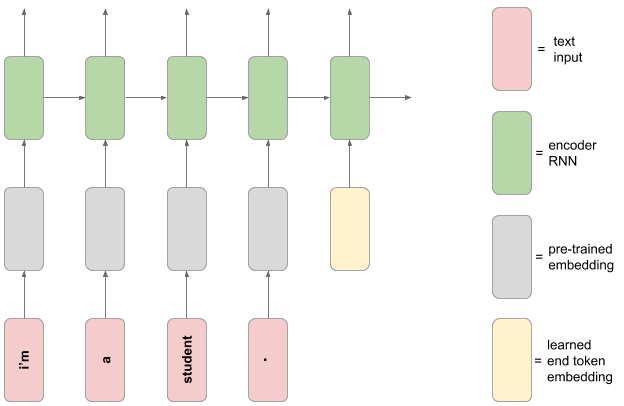

In [281]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

You should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space). _Hint: you may find it helpful in the call method to use the tf.tile function to replicate the end token embedding across every element in the batch._
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [282]:
class MyLayer(tf.keras.layers.Layer):

  def __init__(self):

    super(MyLayer, self).__init__()
    self.emb_space = tf.Variable(initial_value=tf.random.uniform(shape=(128,)), trainable=True)
  def call(self, inputs):

   output = tf.tile(tf.reshape(self.emb_space, shape=(1, 1, self.emb_space.shape[0])), [tf.shape(inputs)[0], 1, 1])

   return tf.keras.layers.concatenate([inputs, output], axis=1)

mylayer = MyLayer()
            

In [283]:

for elem in train_dataset.take(1):
    print(elem[0].shape)

(16, 13, 128)


In [284]:
layer = End_token()
for elem in train_dataset.take(1):
    print(mylayer(elem[0]).shape)

(16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [285]:
input_1 = tf.keras.Input(batch_shape = (None , 13 ,128)) 
h = mylayer(input_1) 
h = tf.keras.layers.Masking(mask_value=0 , name = 'masking')(h)
h , state_h, state_c = tf.keras.layers.LSTM(512,  return_state=True)(h)
encoder_model = tf.keras.Model(inputs=input_1, outputs=[state_h, state_c])

In [286]:
for elem in train_dataset.take(1):
    print(encoder_model(elem[0]))

[<tf.Tensor: shape=(16, 512), dtype=float32, numpy=
array([[ 0.00509756, -0.05169513,  0.05703433, ..., -0.01546442,
         0.05871961, -0.01439377],
       [ 0.00127564, -0.04801565,  0.07110998, ..., -0.00366902,
         0.05511308, -0.00933113],
       [-0.01353694, -0.04569888,  0.0697971 , ..., -0.01288749,
         0.0598346 ,  0.00046273],
       ...,
       [ 0.00702877, -0.04677901,  0.07623908, ..., -0.00294392,
         0.05730511, -0.00433853],
       [ 0.01745146, -0.04108596,  0.0612024 , ...,  0.0024703 ,
         0.0498921 , -0.00223866],
       [-0.00108069, -0.05753475,  0.06345296, ..., -0.00896751,
         0.05951222, -0.00100768]], dtype=float32)>, <tf.Tensor: shape=(16, 512), dtype=float32, numpy=
array([[ 0.01007412, -0.11412761,  0.08905249, ..., -0.02942003,
         0.12510815, -0.02692109],
       [ 0.00252258, -0.10611078,  0.111256  , ..., -0.00695732,
         0.1175033 , -0.01748482],
       [-0.02679323, -0.1009824 ,  0.10899645, ..., -0.02442864,
  

In [287]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
my_layer_4 (MyLayer)         (None, 14, 128)           128       
_________________________________________________________________
masking (Masking)            (None, 14, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

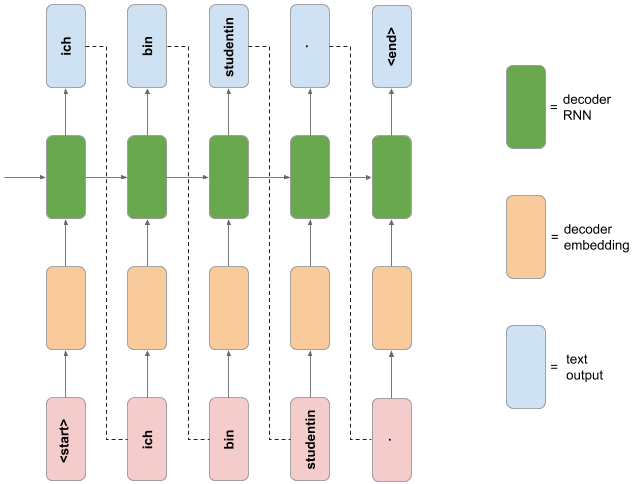

In [288]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

You should now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [289]:
class decoder_model(tf.keras.Model):
    def __init__(self):
        super(decoder_model, self).__init__()
        self.embedding1 = tf.keras.layers.Embedding(input_dim=max_german_tokens+1, output_dim=128, mask_zero=True)
        self.LSTM_2 = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)
        self.dense_d = tf.keras.layers.Dense(max_german_tokens+1)
    def call(self, inputs, hidden_state=None, cell_state=None):
        x = self.embedding1(inputs)
        if hidden_state is None and cell_state is None:
         x , h_state , c_state = self.LSTM_2(x)
        else:
          x , h_state , c_state = self.LSTM_2(x , initial_state = [hidden_state , cell_state])
        return self.dense_d(x),h_state,c_state

In [290]:
decoder = decoder_model()

for en , gr in train_dataset.take(1):
  h , c = encoder_model(en)
  out , h , c = decoder(gr ,hidden_state= h ,cell_state = c)

decoder.summary()

Model: "decoder_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  735232    
_________________________________________________________________
lstm_10 (LSTM)               multiple                  1312768   
_________________________________________________________________
dense_5 (Dense)              multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
You should now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [291]:
optimizer_obj = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
variables = encoder_model.trainable_variables + decoder.trainable_variables  

In [292]:

@tf.function
def grad_fn(en_input, ger_input, ger_output, loss):
  with tf.GradientTape() as tape:
    enc_hidden_s, enc_cell_s = encoder_model(en_input)
    dec_output, dec_hidden_s, dec_cell_s = decoder(ger_input, enc_hidden_s,enc_cell_s)
    loss_value = loss(ger_output, dec_output)
  return loss_value, tape.gradient(loss_value, variables)


In [293]:
def train_resnet( num_epochs, dataset, val_dataset , grad_fn , optimizer, loss):

  train_loss_results = []
  val_loss_results = []
  for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_epoch_loss_avg = tf.keras.metrics.Mean()

    for en, ger in train_dataset:
      dec_inputs, dec_outputs = ger[:, :-1], ger[:, 1:]
      loss_value, grads= grad_fn(en, dec_inputs, dec_outputs, loss)
      optimizer.apply_gradients(zip(grads, variables))
      epoch_loss_avg(loss_value)


    for en, ger in validation_dataset:
      dec_inputs, dec_outputs = ger[:, :-1], ger[:, 1:]
      hidden_s, cell_s = encoder_model(en)
      model_preds, _, _ = decoder(dec_inputs, hidden_s, cell_s)
      val_epoch_loss_avg(loss(dec_outputs, model_preds))


    train_loss_results.append(epoch_loss_avg.result())
    val_loss_results.append(val_epoch_loss_avg.result())
    print(" Epoch :{:03d} ,  Loss: {:.3f} ,  Val_Loss: {:.3f}".format(epoch,epoch_loss_avg.result(), val_epoch_loss_avg.result()))
  return train_loss_results,val_loss_results

In [294]:
train_loss_results,val_loss_results = train_resnet(20, train_dataset, validation_dataset ,grad_fn, optimizer_obj , loss_obj)

 Epoch :000 ,  Loss: 5.406 ,  Val_Loss: 4.781
 Epoch :001 ,  Loss: 4.280 ,  Val_Loss: 3.970
 Epoch :002 ,  Loss: 3.407 ,  Val_Loss: 3.246
 Epoch :003 ,  Loss: 2.595 ,  Val_Loss: 2.587
 Epoch :004 ,  Loss: 1.858 ,  Val_Loss: 2.005
 Epoch :005 ,  Loss: 1.240 ,  Val_Loss: 1.561
 Epoch :006 ,  Loss: 0.802 ,  Val_Loss: 1.301
 Epoch :007 ,  Loss: 0.538 ,  Val_Loss: 1.178
 Epoch :008 ,  Loss: 0.383 ,  Val_Loss: 1.127
 Epoch :009 ,  Loss: 0.289 ,  Val_Loss: 1.111
 Epoch :010 ,  Loss: 0.227 ,  Val_Loss: 1.104
 Epoch :011 ,  Loss: 0.184 ,  Val_Loss: 1.112
 Epoch :012 ,  Loss: 0.150 ,  Val_Loss: 1.124
 Epoch :013 ,  Loss: 0.125 ,  Val_Loss: 1.135
 Epoch :014 ,  Loss: 0.106 ,  Val_Loss: 1.143
 Epoch :015 ,  Loss: 0.094 ,  Val_Loss: 1.155
 Epoch :016 ,  Loss: 0.083 ,  Val_Loss: 1.162
 Epoch :017 ,  Loss: 0.077 ,  Val_Loss: 1.164
 Epoch :018 ,  Loss: 0.072 ,  Val_Loss: 1.179
 Epoch :019 ,  Loss: 0.067 ,  Val_Loss: 1.183


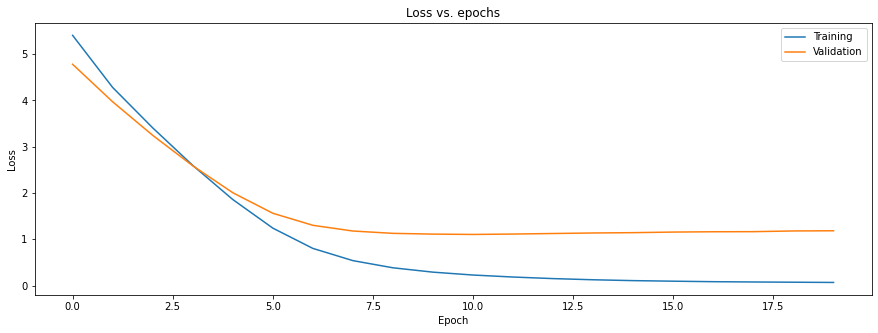

In [297]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(train_loss_results)
plt.plot(val_loss_results)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')



## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [299]:
samples = np.random.choice(len(preprocessed_En), 5, replace=False)

for i, sample in enumerate(samples):
  en = tf.strings.split(preprocessed_En[sample])
  en_emb = embedding_layer(en)
  padding = [[tf.math.maximum(13-tf.shape(en_emb)[0],0), 0], [0,0]]
  en_emb_pad = tf.expand_dims(tf.pad(en_emb, padding), axis=0)
  result = list()
  hidden_s, cell_s = encoder_model(en_emb_pad)
  dec_input = tf.Variable([[tokenizer.word_index['<start>']]])

  for t in range(pad_En_seq_traning.element_spec[1].shape[1]):
    dec_output, hidden_s, cell_s = decoder(dec_input, hidden_s, cell_s)
    dec_output = tf.squeeze(tf.argmax(dec_output, axis=2)).numpy()
    if dec_output == tokenizer.word_index['<end>']:

      break

    result.append(tokenizer.index_word[dec_output])
    dec_input = tf.Variable([[dec_output]])
  result = ' '.join(word for word in result)
  print("Sample: {}".format(i + 1))
  print("English Sentence: {}".format(preprocessed_En[sample]))
  print("German Sentence: {}".format(modified_gr[sample]))
  print("German Translation: {}".format(result))
  print('-' * 5)

Sample: 1
English Sentence: he himself did it .
German Sentence: <start> er hat es selbst gemacht . <end>
German Translation: er hat es nicht mehr geschrieben .
-----
Sample: 2
English Sentence: tom isn't skinny .
German Sentence: <start> tom ist nicht duenn . <end>
German Translation: tom ist nicht duenn .
-----
Sample: 3
English Sentence: show it to me .
German Sentence: <start> zeig es mir . <end>
German Translation: zeig es mir .
-----
Sample: 4
English Sentence: i'm good .
German Sentence: <start> mir geht's gut . <end>
German Translation: ich bin reif .
-----
Sample: 5
English Sentence: he's good .
German Sentence: <start> er ist gut . <end>
German Translation: er ist schlecht .
-----
